In [1]:
import numpy as np

In [2]:
# Build tree ... this is going to be tricky
def backtrace(frame, RMSD_frame, start_frame, print_trace=True):
    traj_length = 0
    trace = []
    trace.append(RMSD_frame[frame])
    r, s, f, rmsd = RMSD_frame[frame]
    fr, fs, ff, frmsd = RMSD_frame[frame]
    #print(f'Frame {frame:6d} is round {int(r):3d}, simulation {int(s):3d} and frame {int(f):3d}, rmsd {rmsd:6.3f} A')
    while r > 1:
        last_frame = start_frame[int(r)][int(s)]
        trace.append(RMSD_frame[last_frame])
        r, s, f, rmsd = RMSD_frame[last_frame]
    #    print(f'  which is from round {int(r):3d}, simulation {int(s):3d} and frame {int(f):3d}, rmsd {rmsd:6.3f} A')
    if print_trace:
        print(f'To arrive at frame {frame:6d} (round {int(fr):3d}, simulation {int(fs):3d} and frame {int(ff):3d}, rmsd {frmsd:6.3f} A):')
    for t in trace[::-1]: 
        r, s, f, rmsd = t
        traj_length += int(f)
        if print_trace:
            print(f'  From round {int(r):3d}, simulation {int(s):3d} and frame 0 to {int(f):3d} (rmsd {rmsd:6.3f} A)')
    if print_trace:
        print(f'Total traj length = {traj_length / 100} ns')
    return trace

In [3]:
def output_traj(frame, RMSD_frame, start_frame, psf=None, fname='traj.dcd'):
    try:
        import mdtraj
    except:
        print("mdtraj is not installed")
        return None
    if psf is None:
        print("Supply psf and try again")
        return None
    trace = backtrace(frame, RMSD_frame, start_frame, print_trace=False)[::-1]
    for idx, t in enumerate(trace):
        r, s, f, rmsd = t
        print(f'  From round {int(r):3d}, simulation {int(s):3d} and frame 0 to {int(f):3d} (rmsd {rmsd:6.3f} A)')
        if idx == 0:
            #traj = mdtraj.load(f'../Simulations/{int(r)}/{int(s)}/BBA_init.pdb', top=psf)
            traj = mdtraj.load(f'../Simulations/{int(r)}/{int(s)}/BBA_sample.dcd', top=psf)[:int(f)+1]
        else:
            #traj += mdtraj.load(f'../Simulations/{int(r)}/{int(s)}/BBA_init.pdb', top=psf)
            traj += mdtraj.load(f'../Simulations/{int(r)}/{int(s)}/BBA_sample.dcd', top=psf)[:int(f)+1]
    traj.save(fname)

In [15]:
# Get starting frames every round
start_frame = {}
for log in ['test0.log']:
    print(log)
    with open(log,'r') as f:
        cont = f.readlines()
    for idx, line in enumerate(cont):
        if "We are in round" in line:
            current_round = int(line.split()[-1].strip('!'))
        if "DBSCAN" in line:
            for idy in range(idx, idx+10):
                if cont[idy].startswith('['):
                    #print(cont[idy])
                    start_frame[current_round+1] = [int(x.strip(']')) for x in cont[idy].strip('[').split()]
                    break
start_frame[0] = [0]*6
start_frame[1] = [0]*6
print(current_round)
RMSD_frame = np.load(f'../Simulations/data/RMSD_rounds_0_to_{current_round-1}.npy')
#print(RMSD_frame.shape)
#print(start_frame)

test0.log
36


In [18]:
def draw_progress(RMSD_frame, start_frame, frames=None):
    import matplotlib.pyplot as plt
    RMSD_plot = np.zeros((len(RMSD_frame), 2))
    RMSD_plot[:, 0] = RMSD_frame[:, 0] + (1+RMSD_frame[:, 2])/(1+np.max(RMSD_frame[:, 2]))
    RMSD_plot[:, 1] = RMSD_frame[:, -1]
    start_plot = []
    # start_frame[0] = start_frame[1]
    for key in start_frame:
        for val in start_frame[key]:
            start_plot.append([key, RMSD_frame[val, -1]])
    start_plot = np.array(start_plot)
    RMSD_plot = np.vstack([RMSD_plot, start_plot])
    
    plt.figure(dpi=300, figsize=(5, 15))
    plt.hlines(range(0, int(np.max(RMSD_frame[:,0])) + 1, 1), 
               np.min(RMSD_frame[:, -1]), np.max(RMSD_frame[:, -1]), 'k', linewidth=0.3, alpha=0.5)
    plt.scatter(RMSD_plot[:, 1], RMSD_plot[:, 0], s=0.3, c='k', marker=',', alpha=0.1)
    plt.scatter(start_plot[:, 1], start_plot[:, 0], s=0.8, c='tab:red')
    plt.ylim([-0.05, np.max(RMSD_plot[:,0])])
    plt.grid(alpha=0.3)
    plt.gca().invert_yaxis()
    

    if frames is None:
        return None
    
    if type(frames) is int:
        frames = [frames]

    for frame in frames:
        print(f'building trace for frame {frame}')
        trace = backtrace(frame, RMSD_frame, start_frame, print_trace=True)[::-1]
        trace_frame = np.empty((0, RMSD_frame.shape[-1]))
        for idx, t in enumerate(trace):
            r, s, f, rmsd = t
            # print(r, s, f, rmsd)
            # print(RMSD_frame[(np.isclose(RMSD_frame[:, 0], r)) * (np.isclose(RMSD_frame[:, 1], s)) * (RMSD_frame[:, 2] <= f)])
            RMSD_start = [r, s, -1, RMSD_frame[start_frame[int(r)][int(s)], -1]]
            trace_frame = np.vstack([trace_frame, 
                                     RMSD_start,
                                     RMSD_frame[(np.isclose(RMSD_frame[:, 0], r)) * (np.isclose(RMSD_frame[:, 1], s)) * (RMSD_frame[:, 2] <= f)]])
        # print(trace_frame)
        trace_plot = np.zeros((len(trace_frame), 2))
        trace_plot[:, 0] = trace_frame[:, 0] + (1+trace_frame[:, 2])/(1+np.max(RMSD_frame[:, 2]))
        trace_plot[:, 1] = trace_frame[:, -1]
        plt.plot(trace_plot[:, 1], trace_plot[:, 0], '-.', linewidth=0.5, markersize=0.5)


building trace for frame 77613
To arrive at frame  77613 (round  32, simulation   2 and frame  13, rmsd  3.973 A):
  From round   0, simulation   0 and frame 0 to 265 (rmsd 20.161 A)
  From round   2, simulation   5 and frame 0 to 353 (rmsd 16.423 A)
  From round   4, simulation   1 and frame 0 to 134 (rmsd 17.047 A)
  From round   7, simulation   5 and frame 0 to 235 (rmsd 13.730 A)
  From round   9, simulation   3 and frame 0 to 286 (rmsd 11.617 A)
  From round  12, simulation   0 and frame 0 to 130 (rmsd  8.191 A)
  From round  15, simulation   1 and frame 0 to  92 (rmsd  5.588 A)
  From round  17, simulation   3 and frame 0 to  28 (rmsd  5.894 A)
  From round  19, simulation   2 and frame 0 to  94 (rmsd  4.840 A)
  From round  22, simulation   1 and frame 0 to   7 (rmsd  4.767 A)
  From round  24, simulation   2 and frame 0 to  35 (rmsd  4.076 A)
  From round  26, simulation   0 and frame 0 to   6 (rmsd  4.358 A)
  From round  28, simulation   1 and frame 0 to  53 (rmsd  4.223 A)
 

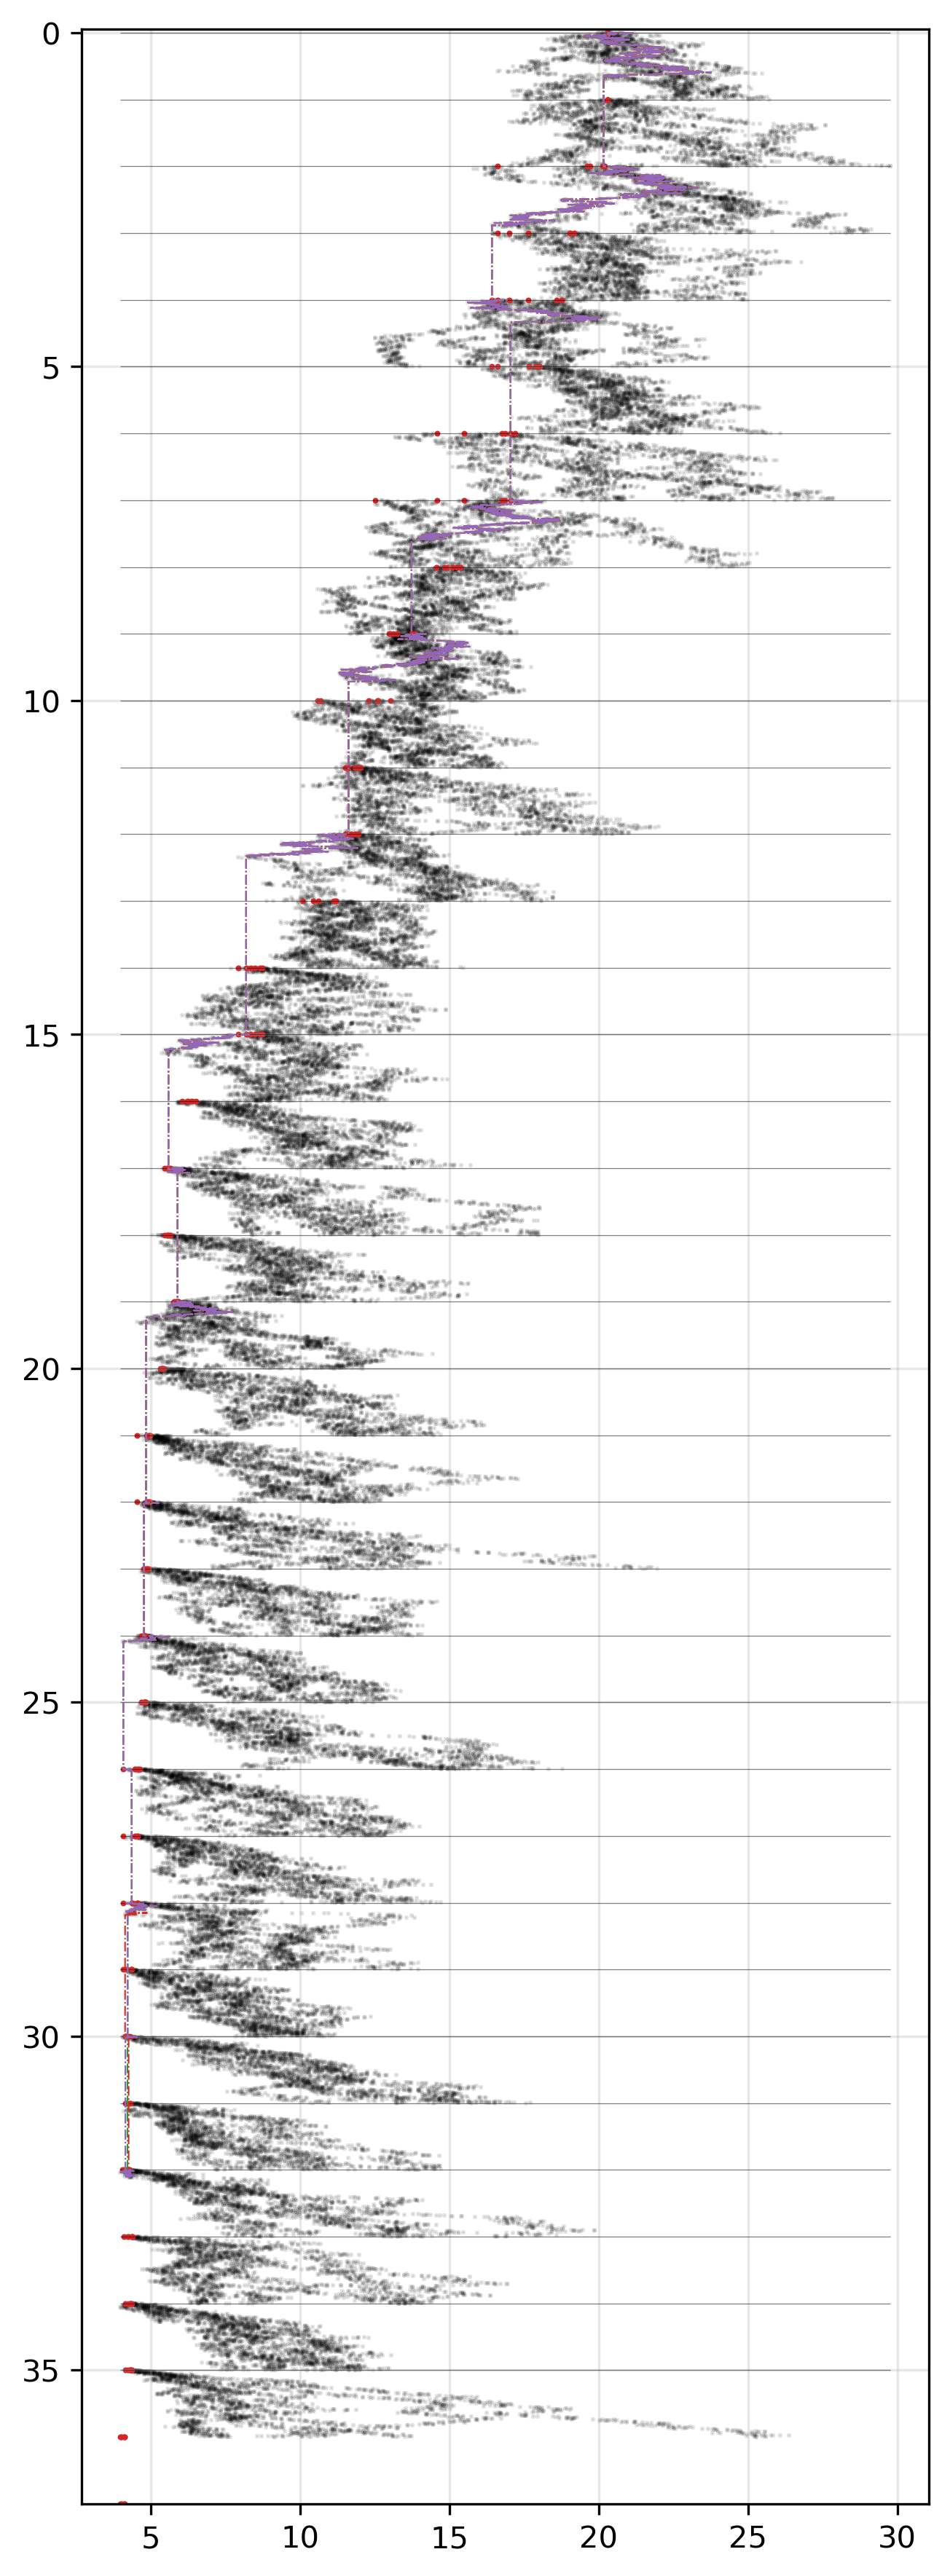

In [22]:
draw_progress(RMSD_frame, start_frame, 
              #rames=np.arange(len(RMSD_frame))[RMSD_frame[:,-1] < 2.5][:1],
              frames=np.argsort(RMSD_frame[:,-1])[:50:10])

In [21]:
# for x in np.argsort(RMSD_frame[:, -1])[:1]:
#     #backtrace(x, RMSD_frame, start_frame)
#     output_traj(x, RMSD_frame, start_frame, psf='../Structures/1FME_wb_Cl.psf')
#     print()


print(f'There are {np.sum(RMSD_frame[:, -1] < 4)} frames < 2.5 A RMSD to target')

There are 3 frames < 2.5 A RMSD to target
